In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

In [2]:
def retrieve_df():
    # Read the soup object from a file
    with open('../data/channels_df', "rb") as f:
        return pickle.load(f)    


In [3]:
channels_df = retrieve_df()

In [36]:
channels_df.describe()

total_views      uploads   subscribers  daily_avg_sub  \
count  7.390000e+02   739.000000  7.390000e+02     739.000000   
mean   9.347260e+06   158.035183  8.181389e+04     190.395129   
std    2.727809e+07   240.316935  2.519955e+05     825.092383   
min    0.000000e+00     1.000000  6.000000e+00    -100.000000   
25%    1.085300e+04    43.000000  2.470000e+02       1.000000   
50%    1.694430e+05    97.000000  2.470000e+03       3.000000   
75%    2.752924e+06   194.000000  3.915000e+04      44.500000   
max    2.363485e+08  3914.000000  2.850000e+06   12300.000000   

       daily_avg_views         age  views_per_video  weekly_videos  
count     7.390000e+02  739.000000     7.390000e+02     739.000000  
mean      3.220979e+04  473.991881     1.356721e+05       2.484844  
std       1.169389e+05  171.486273     6.879138e+05       3.650996  
min       1.000000e+00   33.000000     0.000000e+00       0.000000  
25%       3.700000e+01  362.500000     1.200000e+02       0.700000  
50%       4.610000e+02  496.000000     1.570500e+03       1.500000  
75%       7.828500e+03  623.000000     3.068520e+04       3.000000  
max       1.635123e+06  733.000000     1.114221e+07      39.200000

In [35]:
# Removing "viral" outliers
channels_df = channels_df[channels_df.subscribers < 5000000]
channels_df = channels_df[channels_df.daily_avg_views > 0]
channels_df = channels_df[channels_df.total_views < 300000000]

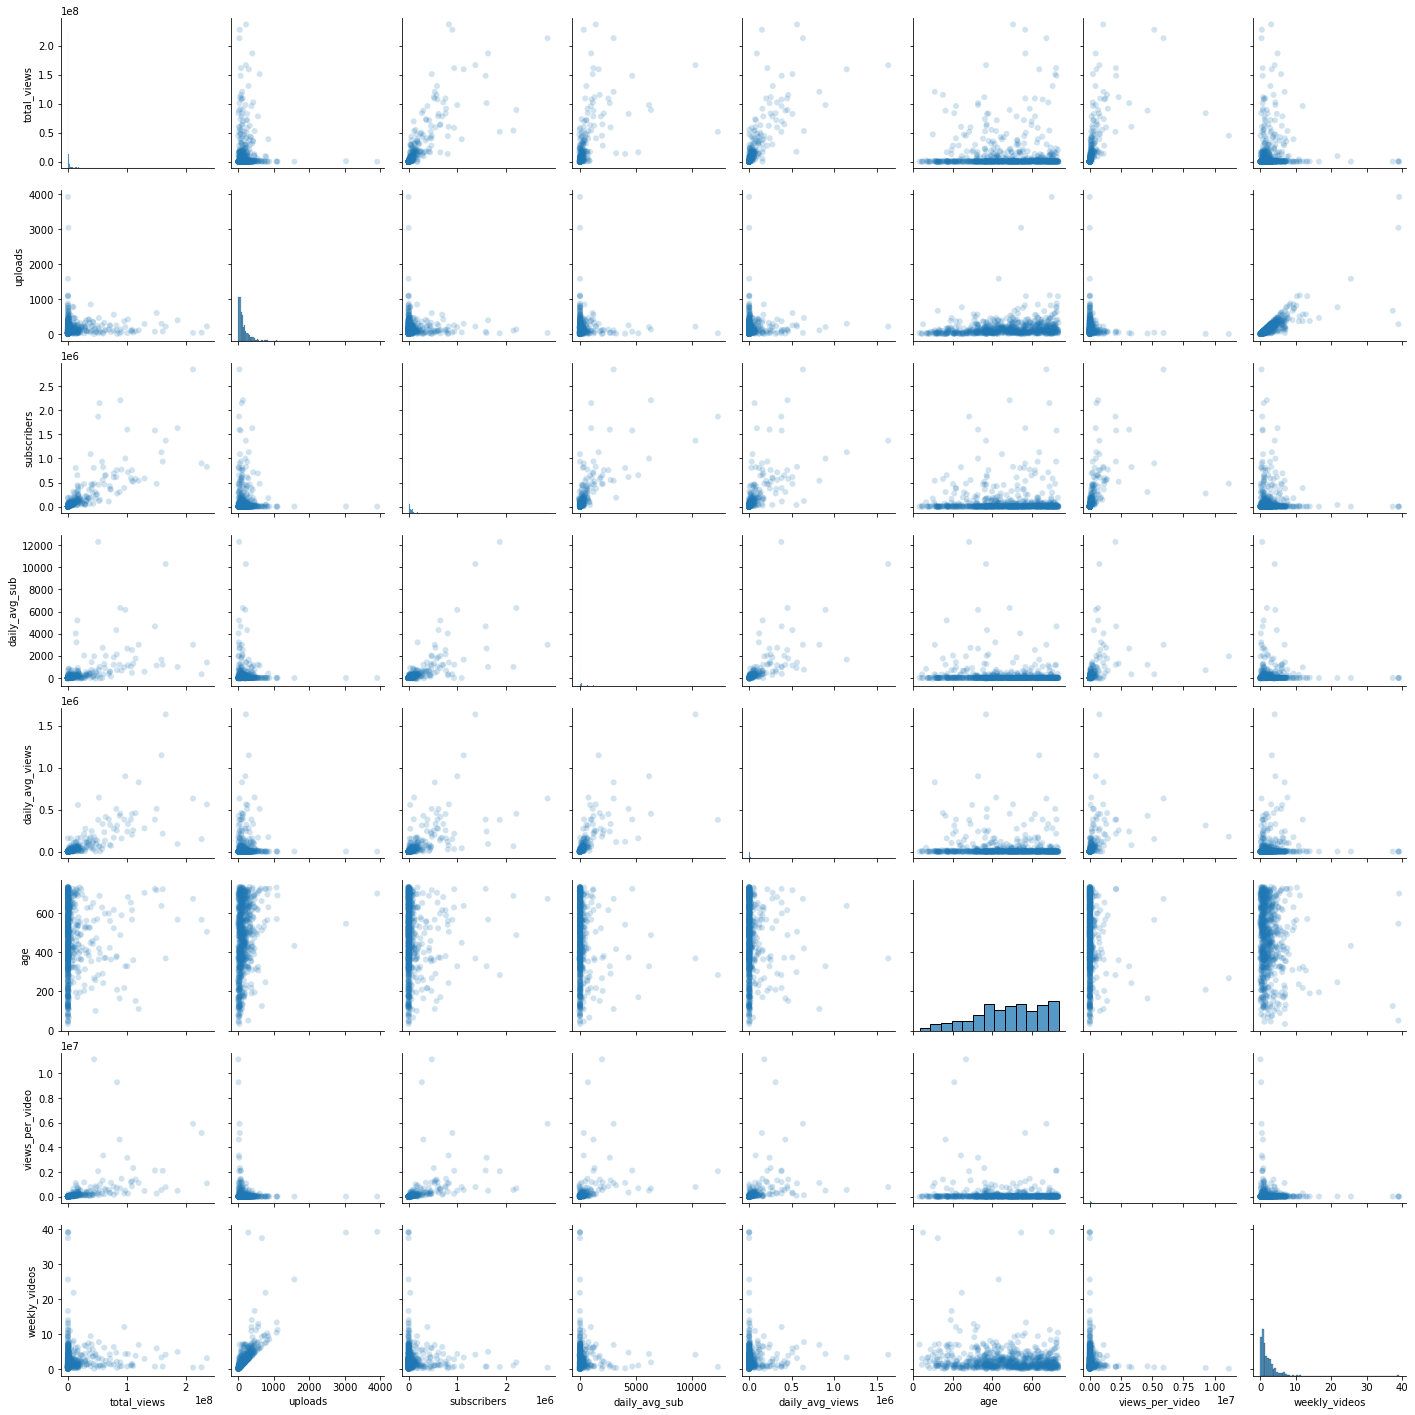

In [37]:
sns.pairplot(channels_df, plot_kws=dict(alpha=.2, edgecolor='none'));

In [43]:
features, target = ['uploads', 'subscribers', 'daily_avg_sub', 'daily_avg_views', 'age', 'views_per_video', 'weekly_videos'], 'total_views'
X, y = channels_df[features], channels_df[target]

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

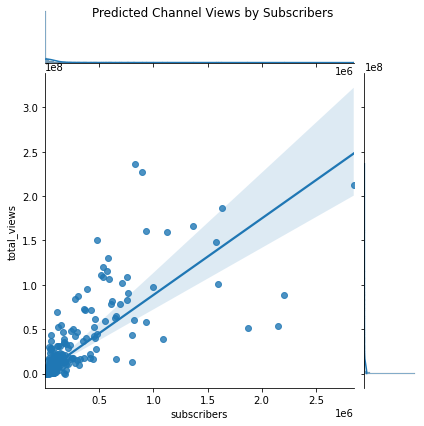

In [51]:
preds = lr.predict(X)
plt = sns.jointplot(x=channels_df.subscribers, y=y, kind='reg')
plt.fig.suptitle("Predicted Channel Views by Subscribers")
plt.savefig('../img/pairplot.png', format='png');

In [47]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

In [48]:
RMSE(y,preds)

11611033.385522628

/home/aaron/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


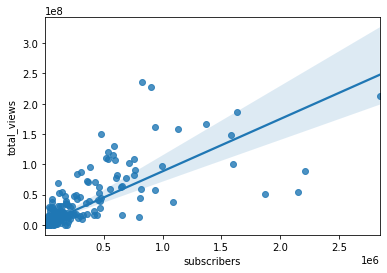

In [40]:
y = channels_df[target]
x = channels_df['subscribers']

g = sns.regplot(x, y)
g.set_xlabel('subscribers')
g.set_ylabel(target);

In [41]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    lr = LinearRegression()
    lr.fit(x,y)
    pred = lr.predict(x)
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [42]:
diagnostic_plot(x.reshape(s,1), channels_df[target]) # we reshape x to turn it into a tall column

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
train_preds = lr.predict(X_train)
sns.jointplot(x = train_preds, y = y_train, kind='reg')

In [7]:
def split_and_validate(X, y):    
    # perform train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [8]:
split_and_validate(X, y)


Validation R^2 score was: 0.9100467090226381
Feature coefficient results: 

uploads : 4124.52
subscribers : 77.48
daily_avg_sub : -16816.06
daily_avg_views : 179.65
age : -765.54
views_per_video : 3.65
weekly_videos : 25625.94


In [9]:
raise Exception('Pause')

Exception: Pause

In [16]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [17]:
def test_setup(splits, random_state, alpha):
    #run the CV
    kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_las_r2s, cv_lm_enet_r2s = [],  [],  [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):
        
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=alpha)
        lm_las = Lasso(alpha=alpha)
        lm_enet = ElasticNet(alpha=alpha)

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
            
        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        lm_reg.fit(X_train_scaled, y_train)
        lm_las.fit(X_train_scaled, y_train)
        lm_enet.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
        cv_lm_las_r2s.append(lm_las.score(X_val_scaled, y_val))
        cv_lm_enet_r2s.append(lm_enet.score(X_val_scaled, y_val))

    las_rmse = mean_squared_error(y_val, lm_las.predict(X_val), squared=False)
    
    print('Lass rmse: ', las_rmse, '\n')

    print('Simp scores: ', cv_lm_r2s)
    print('Ridg scores: ', cv_lm_reg_r2s)
    print('Lass scores: ', cv_lm_las_r2s)
    print('Elas scores: ', cv_lm_enet_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Lasso mean cv r^2: {np.mean(cv_lm_las_r2s):.3f} +- {np.std(cv_lm_las_r2s):.3f}')
    print(f'ElasticNet mean cv r^2: {np.mean(cv_lm_enet_r2s):.3f} +- {np.std(cv_lm_enet_r2s):.3f}')

In [18]:
test_setup(5, 42, 100)

Lass rmse:  21870291732899.715 

Simp scores:  [0.9966736996871645, 0.6741244092645489, 0.5721987311464186, 0.6344736665055284, -2.391463966137702]
Ridg scores:  [0.9890234460763359, 0.3052828437858707, 0.7159400686707758, 0.5998934633926872, -0.12939265250255438]
Lass scores:  [0.9966736907841282, 0.6741147840638927, 0.5722300147195205, 0.6344693562773146, -2.3913736317726033]
Elas scores:  [0.09651163150204045, 0.09037410249411615, 0.12896729944093255, 0.058619136105654945, -0.08415249160148686] 

Simple mean cv r^2: 0.097 +- 1.253
Ridge mean cv r^2: 0.496 +- 0.382
Lasso mean cv r^2: 0.097 +- 1.253
ElasticNet mean cv r^2: 0.058 +- 0.075
